1. Read and clean data
We start off by importing the two data sets from Denmark Statistics, statistikbanken.dk:

1. EJ56: skriv noget om huspris
2. realindkomst udvilking


We import EJ56 as API-files.

In [ ]:
import numpy as np
import pandas as pd
import datetime

import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`
import matplotlib.pyplot as plt

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
national = DstApi('EJ56') 
tabsum = national.tablesummary(language='en')
display(tabsum)


Table EJ56: Price index for sales of property by region, category of real property, unit and time
Last update: 2024-03-26T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,17,000,All Denmark,11,Province Nordjylland,False
1,EJENDOMSKATE,3,0111,One-family houses,2103,"Owner-occupied flats, total",False
2,TAL,3,100,Index,310,Percentage change compared to same quarter the...,False
3,Tid,128,1992K1,1992Q1,2023K4,2023Q4,True


I want the following for each variable:

OMRÅDE to be All Denmark (Code 000) and Copgenhagen
EJENDOMSKATE to be One-family houses and Ejerlejligheder (Code TOT)
Alder to be all ages from 1-105, where i sum over the ages from 105-125
HERKOMST to be Immigrants from non-western countries (Code 25)
Tid to be the years from 2019-2024, where i only look at the first quarters
I see that the data contains 5 different variables. I want to sort the data, but in order to see which value the variables can take, i use the code below for the variables:

In [35]:
for variable in tabsum['variable name']:
    print(variable+':')
    display(national.variable_levels(variable, language='en'))


# Remove " years" in variable "ALDER" and convert to string




OMRÅDE:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,01,Province Byen København
3,02,Province Københavns omegn
4,03,Province Nordsjælland
5,04,Province Bornholm
6,085,Region Sjælland
7,05,Province Østsjælland
8,06,Province Vest- og Sydsjælland
9,083,Region Syddanmark


EJENDOMSKATE:


,id,text
0,0111,One-family houses
1,0801,Weekend cottages
2,2103,"Owner-occupied flats, total"


TAL:


,id,text
0,100,Index
1,210,Percentage change compared to previous quarter
2,310,Percentage change compared to same quarter the...


Tid:


,id,text
0,1992K1,1992Q1
1,1992K2,1992Q2
2,1992K3,1992Q3
3,1992K4,1992Q4
4,1993K1,1993Q1
...,...,...
123,2022K4,2022Q4
124,2023K1,2023Q1
125,2023K2,2023Q2
126,2023K3,2023Q3


In [36]:
params = national._define_base_params(language='en')

params

{'table': 'ej56',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['*']},
  {'code': 'EJENDOMSKATE', 'values': ['*']},
  {'code': 'TAL', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [52]:
variables = params['variables'] # Returns a view, that we can edit
variables[0]['values'] = ['000', '084']
variables[1]['values'] =['0111']
variables[2]['values'] =['100']
variables[3]['values'] = ['2013K1', '2013K2', '2013K3', '2013K4', '2014K1', '2014K2', '2014K3', '2014K4', 
    '2015K1', '2015K2', '2015K3', '2015K4', '2016K1', '2016K2', '2016K3', '2016K4', '2017K1', '2017K2', '2017K3', '2017K4', 
    '2018K1', '2018K2', '2018K3', '2018K4', '2019K1', '2019K2', '2019K3', '2019K4', '2020K1', '2020K2', '2020K3', '2020K4',
    '2021K1', '2021K2', '2021K3', '2021K4', '2022K1', '2022K2', '2022K3', '2022K4', '2023K1', '2023K2', '2023K3', '2023K4']
params

{'table': 'ej56',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['000', '084']},
  {'code': 'EJENDOMSKATE', 'values': ['0111']},
  {'code': 'TAL', 'values': ['100']},
  {'code': 'Tid',
   'values': ['2013K1',
    '2014K1',
    '2015K1',
    '2016K1',
    '2017K1',
    '2018K1',
    '2019K1',
    '2020K1',
    '2021K1',
    '2022K1',
    '2023K1']}]}

In [50]:
inc_api = national.get_data(params=params)
inc_api.head(22)

,OMRÅDE,EJENDOMSKATE,TAL,TID,INDHOLD
0,All Denmark,One-family houses,Index,2013Q1,65.7
1,Region Hovedstaden,One-family houses,Index,2013Q1,55.9
2,All Denmark,One-family houses,Index,2014Q1,67.1
3,Region Hovedstaden,One-family houses,Index,2014Q1,58.4
4,All Denmark,One-family houses,Index,2015Q1,70.7
5,Region Hovedstaden,One-family houses,Index,2015Q1,62.4
6,All Denmark,One-family houses,Index,2016Q1,74.1
7,Region Hovedstaden,One-family houses,Index,2016Q1,68.1
8,All Denmark,One-family houses,Index,2017Q1,76.5
9,Region Hovedstaden,One-family houses,Index,2017Q1,70.8


/var/folders/9m/01n1bwfs7z3ff725_t5rrylc0000gn/T/ipykernel_25393/89699934.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  }, index=pd.to_datetime(dates))


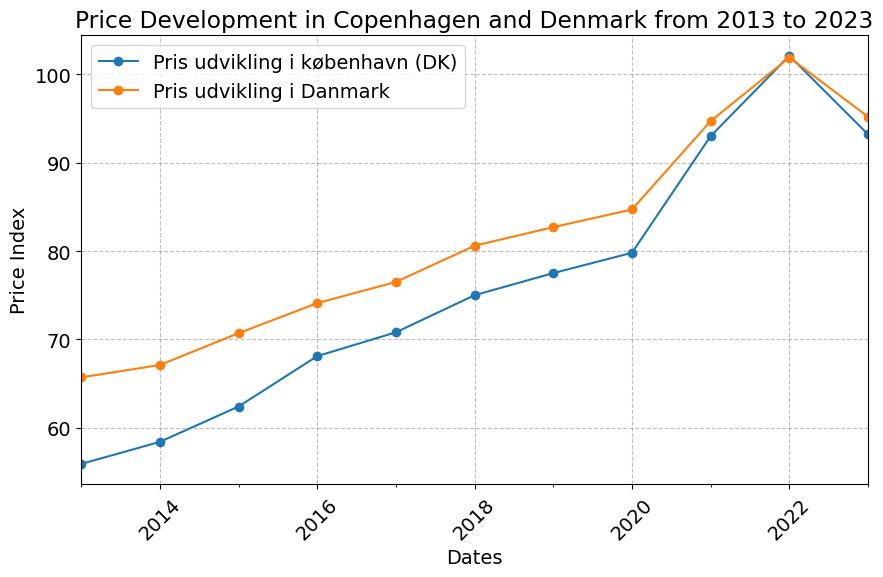

In [57]:
dates = ['2013K1', '2014K1', '2015K1', '2016K1', '2017K1', '2018K1', '2019K1', '2020K1', '2021K1', '2022K1', '2023K1']
# Convert 'K1' to '-Q1' for pandas to understand it as the first quarter
dates = [d.replace('K', '-Q') for d in dates]

kobenhavn_values = [55.9, 58.4, 62.4 , 68.1, 70.8, 75.0, 77.5, 79.8, 93.0, 102.1, 93.2]
Danmark_values = [65.7, 67.1, 70.7, 74.1, 76.5, 80.6, 82.7, 84.7, 94.7, 101.9, 95.2]

# Creating a pandas DataFrame
udvikling = pd.DataFrame({
    'Pris udvikling i københavn (DK)': kobenhavn_values,
    'Pris udvikling i Danmark': Danmark_values
}, index=pd.to_datetime(dates))

# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
udvikling.plot(ax=ax, legend=True, marker='o')

ax.legend(frameon=True)
ax.set_xlabel('Dates')
ax.set_ylabel('Price Index')
ax.set_title('Price Development in Copenhagen and Denmark from 2013 to 2023')
ax.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()